In [106]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck_clean.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck_clean.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck_clean.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import scienceplots
import scienceplots
plt.style.use([
    'default',
    # 'science',
    'acp',
    # 'sp-grid',
    'no-black',
    'no-latex',
    'illustrator-safe'
])

In [108]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SET SEASON

In [109]:
season = 'JA'

### Filename for saved plots

In [110]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

## LOAD MY VERSION OF SATELLITE: 

In [111]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [112]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [113]:
rn_dic_models = {
    'OA_STP':'OA',
}

In [114]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [115]:
from bs_fdbck_clean.constants import path_measurement_data

## Settings: 

In [116]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'SMR'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [117]:
ds_smr_sat = xr.open_dataset(sat_filename)

In [118]:
sat_filename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/satellite/MODIS_postproc_lev2/MODIS_date_SMR.nc')

In [119]:
from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month

In [120]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin(season2month[season])

In [121]:
ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

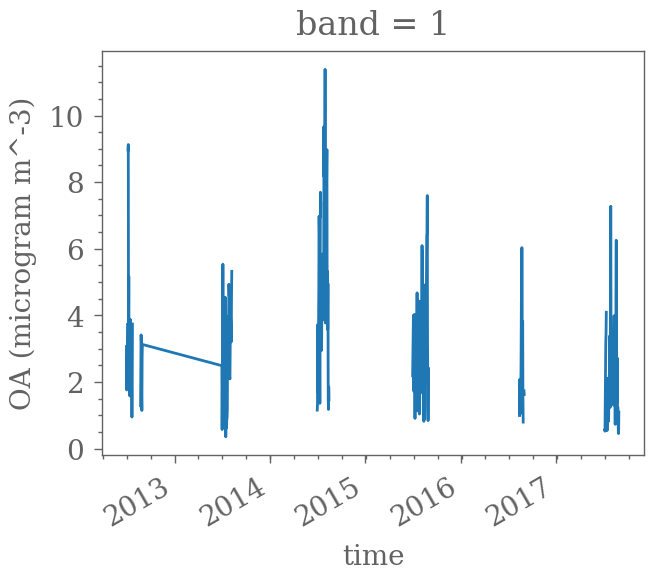

In [122]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [123]:
ds_smr_sat_JA['OA (microgram m^-3)'].quantile([.333333,.666666])

<xarray.DataArray 'OA (microgram m^-3)' (quantile: 2)>
array([1.85296371, 3.42130429])
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6667

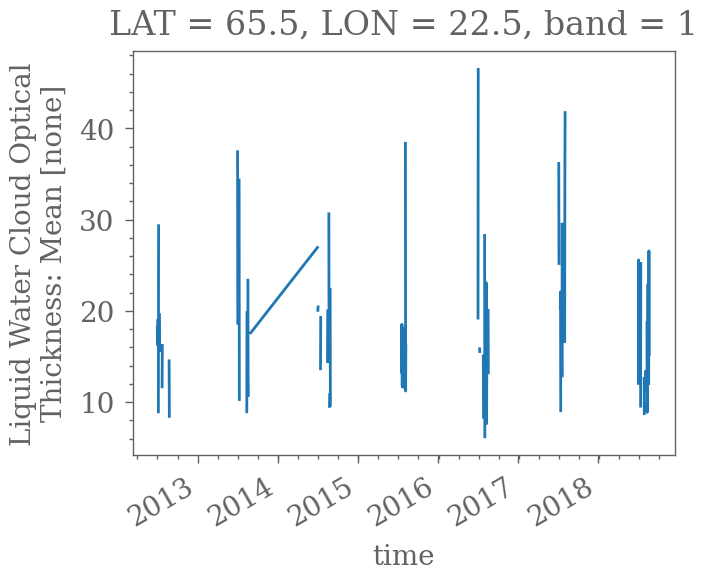

In [124]:
ds_smr_sat_JA['COT'].isel(LAT=0,LON=0).plot()

In [125]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT',]

In [126]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [127]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 434, LAT: 6, LON: 8)
Coordinates:
  * time                 (time) datetime64[ns] 2012-07-01 ... 2018-08-31
  * LAT                  (LAT) float64 65.5 64.5 63.5 62.5 61.5 60.5
  * LON                  (LON) float64 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 3.065 3.065 3.065 ... nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 124.0 132.0 ... 82.0 125.0
    CER (micrometer)     (time, LAT, LON) float32 10.79 11.41 ... 12.57 13.38
    COT                  (time, LAT, LON) float32 18.18 18.75 ... 10.17 14.74

In [128]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [129]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

<AxesSubplot:xlabel='time,LAT,LON'>

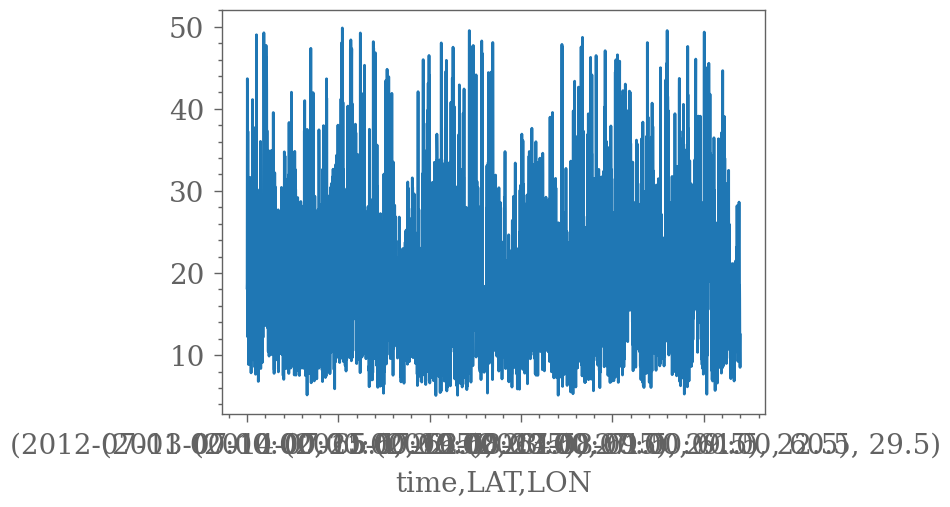

In [130]:
df_smr_sat_JAs['COT'].plot()#.dropna()

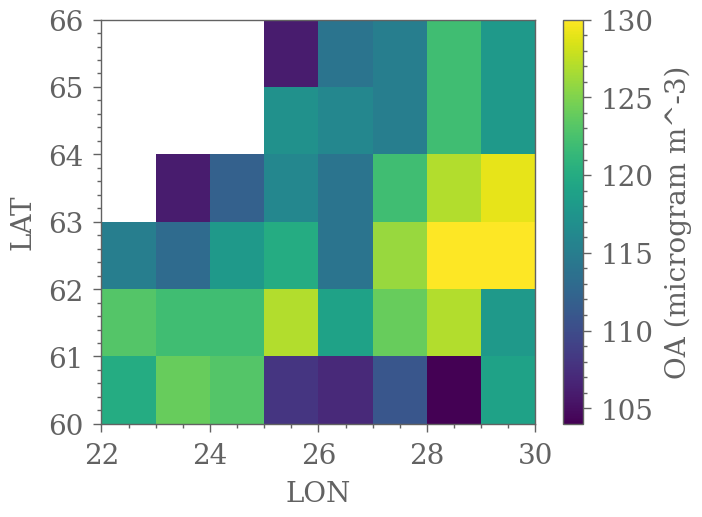

In [131]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [132]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [133]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


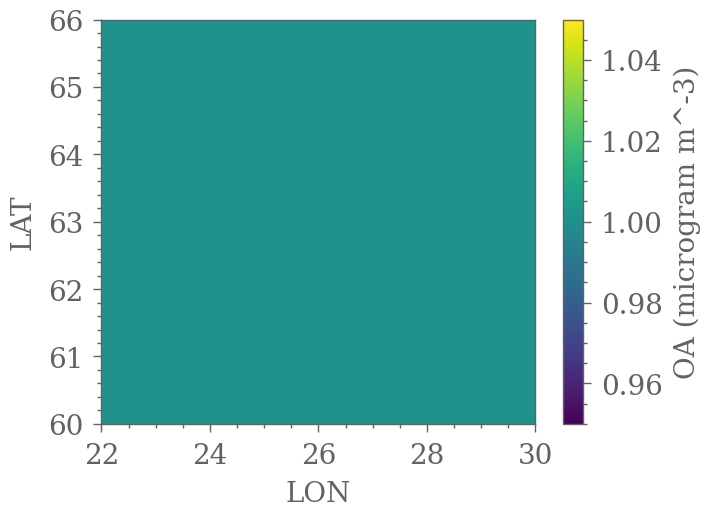

In [134]:
(~da_drop_pixels).plot()

In [135]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

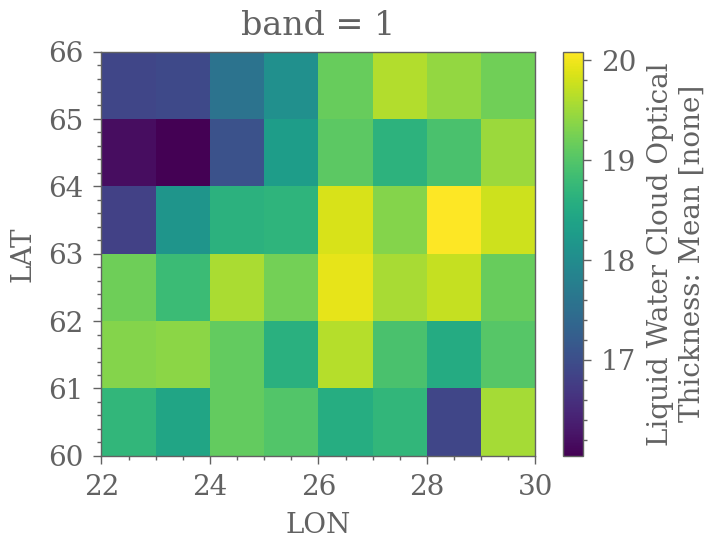

In [136]:
ds_smr_sat_JAs['COT'].mean('time').plot()

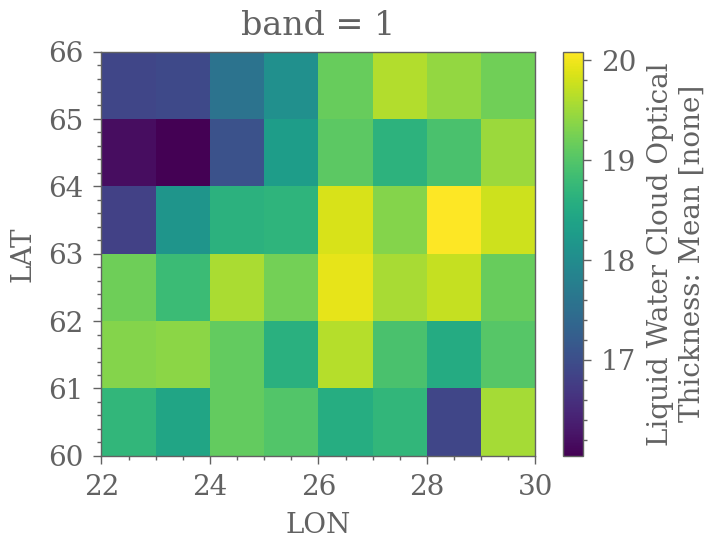

In [137]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([2448., 3504., 2400., 1680.,  672.,  384.,  336.,  336.,   48.,
          48.]),
 array([ 0.35336231,  1.45674178,  2.56012124,  3.66350071,  4.76688017,
         5.87025964,  6.97363911,  8.07701857,  9.18039804, 10.2837775 ,
        11.38715697]),
 <BarContainer object of 10 artists>)

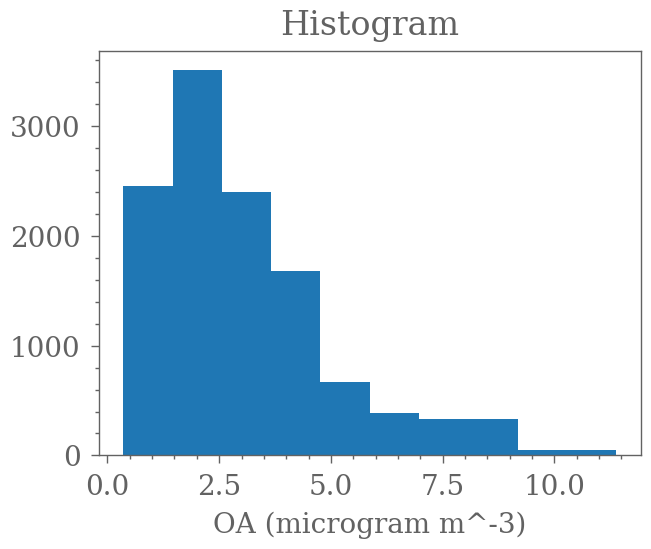

In [138]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [139]:
dic_OA_percentiles = dict()

In [140]:
ds_smr_sat_JAs

<xarray.Dataset>
Dimensions:              (time: 434, LAT: 6, LON: 8)
Coordinates:
  * LAT                  (LAT) float64 65.5 64.5 63.5 62.5 61.5 60.5
  * time                 (time) datetime64[ns] 2012-07-01 ... 2018-08-31
  * LON                  (LON) float64 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 3.065 3.065 3.065 ... nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 124.0 132.0 ... 82.0 125.0
    CER (micrometer)     (time, LAT, LON) float32 10.79 11.41 ... 12.57 13.38
    COT                  (time, LAT, LON) float32 18.18 18.75 ... 10.17 14.74

ds_smr_sat_JAs['OA_high'].to_dataframe().dropna().count()

In [141]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [142]:
df_hyy_1

,,,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
time,lat,lon,,,,
2012-07-01,60.5,22.5,3.065123,NaN,NaN,NaN
2012-07-02,60.5,22.5,1.759205,NaN,NaN,NaN
2012-07-03,60.5,22.5,2.734630,72.0,16.09,7.680000
2012-07-04,60.5,22.5,2.309123,NaN,NaN,NaN
2012-07-05,60.5,22.5,3.726425,191.0,12.94,26.219999
...,...,...,...,...,...,...
2018-08-27,65.5,29.5,NaN,141.0,17.43,13.030000
2018-08-28,65.5,29.5,NaN,NaN,NaN,NaN
2018-08-29,65.5,29.5,NaN,NaN,NaN,NaN


df_smr_sat_JAsad model data:

## Load model data

In [143]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth'
model_name_ukesm  = 'UKESM'

models =[model_name_noresm,model_name_echam,model_name_ec_earth,model_name_ukesm]

### Settings

In [144]:
def lon_sh(l):
    return ((l+180)%360-180) 

def lon_sh360(l):
    return ((l)%360)

### NorESM

In [145]:


lon_lims = [22.,30.]
lat_lims = [60.,66.]

lat_smr = 61.85
lon_smr = 24.28
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'

In [146]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files created in [02-create_file-long_sum.ipynb](02-create_file-long_sum)

#### Input files

In [147]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'

In [148]:

cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [149]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

#### Input files:

In [150]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [151]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [152]:
fn_final_echam_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv')

In [153]:
cases_echam = [case_name_echam]

In [154]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [155]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [156]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [157]:
fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [158]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv')

In [159]:
cases_ec_earth = [case_name_ec_earth]

### UKESM

In [160]:

case_name = 'AEROCOMTRAJ'
case_name_ukesm = 'AEROCOMTRAJ'
time_res = 'hour'
space_res='locations'
model_name='UKESM'
model_name_ukesm ='UKESM'

#### Define some strings for files

In [161]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [162]:
input_path_ukesm = path_extract_latlon_outdata / model_name_ukesm/ case_name_ukesm

In [163]:
fn_final_ukesm = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ukesm_csv = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [164]:
fn_final_ukesm_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv')

In [165]:
cases_ukesm = [case_name_ukesm]

### Read in model data

In [166]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2],parse_dates=[0] )
df_mod_noresm['month'] =df_mod_noresm.index.get_level_values(0).month
df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_echam['month'] =df_mod_echam.index.get_level_values(0).month
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ec_earth['month'] =df_mod_ec_earth.index.get_level_values(0).month

df_mod_ukesm = pd.read_csv(fn_final_ukesm_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ukesm['month'] =df_mod_ukesm.index.get_level_values(0).month

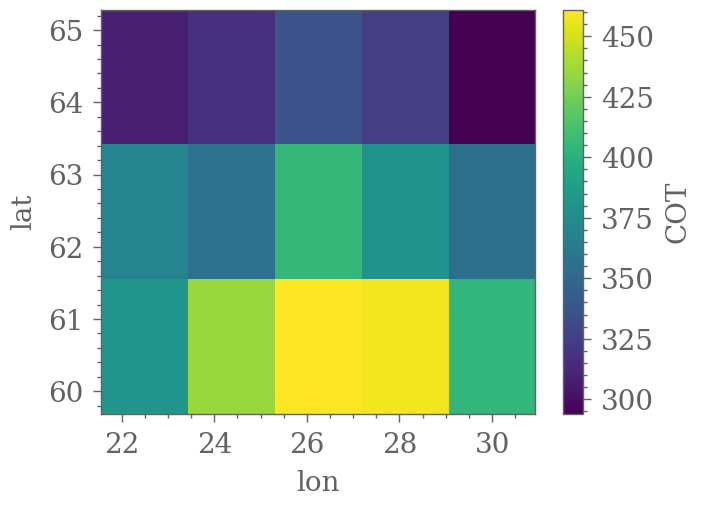

In [167]:
_ds = df_mod_echam.to_xarray()

_ds['time'] = pd.to_datetime(_ds['time'])

#_ds = _ds.where(_ds['time.month'].isin([7,8]))

_ds.count('time')['COT'].plot()

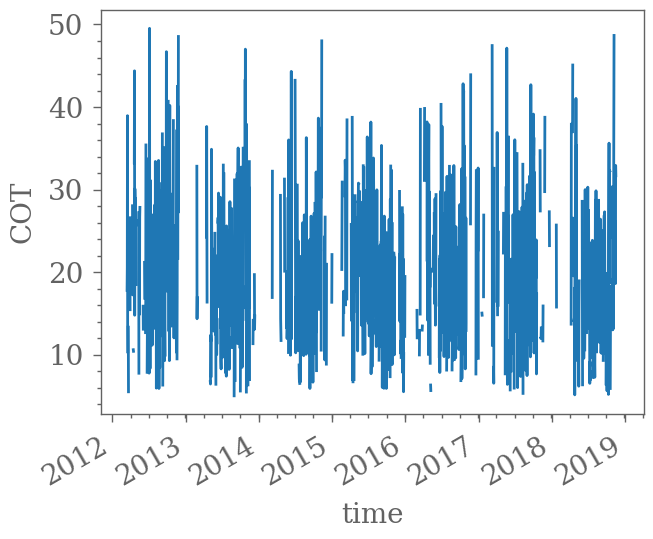

In [168]:
_ds.mean(['lat','lon'])['COT'].plot()

## Pick out months:

In [169]:
df_mod_echam['month']

time        lat        lon   
2012-01-01  64.350730  22.500    1
                       24.375    1
                       26.250    1
                       28.125    1
                       30.000    1
                                ..
2019-01-01  60.620396  22.500    1
                       24.375    1
                       26.250    1
                       28.125    1
                       30.000    1
Name: month, Length: 38370, dtype: int64

In [170]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]

### Organize data in dictionary

In [171]:
_df = df_hyy_1.copy()

In [172]:
df_hyy_1['month'] = df_hyy_1.index.get_level_values(0).month

In [173]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df[model_name_ukesm] = df_mod_ukesm
dic_df['Observations'] = df_hyy_1

### Rename variables:


In [174]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',


}
rn_dic_ukesm = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',


}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
    'OA_STP':'OA',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}
rn_dic_ec_earth = {
    'OA_STP':'OA',
}

In [175]:
model2rndic = {
    model_name_noresm : rn_dic_noresm,
    model_name_ec_earth: rn_dic_ec_earth,
    model_name_echam:rn_dic_echam,
    model_name_ukesm:rn_dic_ukesm,
    'Observations': rn_dic_obs
}

#### Fix NorESM having OA as well as OA_STP

In [176]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations'])

In [177]:
models

['NorESM', 'ECHAM-SALSA', 'EC-Earth', 'UKESM']

In [178]:
for mod in models+ ['Observations']:
    _rn_dic = model2rndic[mod]
    print(mod)
    print(_rn_dic)
    if ('OA' in dic_df[mod].columns) & ('OA_STP' in dic_df[mod].columns):
        if ('OA_STP' in _rn_dic):
            if (_rn_dic['OA_STP']=='OA'):
                dic_df[mod] = dic_df[mod].drop(['OA'], axis=1)
                print('dropping OA in favor of OA_STP')
    dic_df[mod] = dic_df[mod].rename(_rn_dic, axis=1)

NorESM
{'TGCLDLWP_incld': 'CWP', 'TOT_CLD_VISTAU_s_incld': 'COT', 'ACTREL_incld': 'r_eff', 'OA_STP': 'OA'}
dropping OA in favor of OA_STP
ECHAM-SALSA
{'OA_STP': 'OA'}
EC-Earth
{'OA_STP': 'OA'}
UKESM
{'OA_STP': 'OA'}
dropping OA in favor of OA_STP
Observations
{'CWP (g m^-2)': 'CWP', 'CER (micrometer)': 'r_eff', 'OA (microgram m^-3)': 'OA'}


In [179]:
models

['NorESM', 'ECHAM-SALSA', 'EC-Earth', 'UKESM']

In [180]:
for mod in dic_df.keys():
    print(mod)
    print(dic_df[mod].to_xarray())

ECHAM-SALSA
<xarray.Dataset>
Dimensions:         (time: 434, lat: 3, lon: 5)
Coordinates:
  * time            (time) datetime64[ns] 2012-07-01 2012-07-02 ... 2018-08-31
  * lat             (lat) float64 60.62 62.49 64.35
  * lon             (lon) float64 22.5 24.38 26.25 28.12 30.0
Data variables: (12/54)
    station         (time, lat, lon) object 'SMR' 'SMR' 'SMR' ... 'SMR' 'SMR'
    ceff            (time, lat, lon) float64 nan nan nan 0.0 ... 0.0 0.0 nan 0.0
    lcdnc_ct        (time, lat, lon) float64 nan nan nan ... nan 4.478e+07
    ceff_ct         (time, lat, lon) float64 nan nan nan ... 8.257 nan 10.83
    ceff_um         (time, lat, lon) float64 nan nan nan 0.0 ... 0.0 0.0 nan 0.0
    min_cl_tempair  (time, lat, lon) float64 nan nan nan ... 216.5 nan 216.0
    ...              ...
    N100-500        (time, lat, lon) float64 144.6 144.6 144.6 ... 197.7 197.7
    mmrtrN200       (time, lat, lon) float64 4.066e+07 4.066e+07 ... 3.693e+07
    N100            (time, lat, lon) floa

In [181]:
model_name_echam

'ECHAM-SALSA'

## Mask data

### Moved to preprocessing: NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top 

df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.05) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

## Group by cloud water path 

#### Predefined bins

In [182]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ukesm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins['Observations'] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])

### Bin model data:


varl_categories

In [183]:
vs =['OA (microgram m^-3)', 'CWP (g m^-2)', 'CER (micrometer)', 'COT',
       'OA_low', 'OA_high', 'OA_category']

### Calculate CWP and high/low categories in models

In [184]:
varl_categories = ['OA']#,'CLDFREE']

In [185]:
varlist_notna = ['OA','CWP','COT','r_eff']
varlist_notna_noCOT = set(varlist_notna)-set(['COT'])

In [186]:
varlist_notna_noCOT

{'CWP', 'OA', 'r_eff'}

In [187]:
n_bins = 7

for model_name in dic_df.keys():
    
    print(model_name)
    df_mod = dic_df[model_name].copy()
    ## drop nans:
    if model_name in ['UKESM','EC-Earth']:
        _vl = varlist_notna_noCOT
    else:
        _vl = varlist_notna
    df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]


    for v in varl_categories:
        q34 = df_mod[v].quantile(.3333333)
        print(q34)

        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        if v=='OA':
            dic_OA_percentiles[model_name]=dict()
            dic_OA_percentiles[model_name]['33rd']=q34
            dic_OA_percentiles[model_name]['66th']=q66
            dic_OA_percentiles[model_name]['med_high']= df_mod[v][df_mod[v]>q66].median()
            dic_OA_percentiles[model_name]['med_low']= df_mod[v][df_mod[v]<q34].median()


        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( q34<df_mod[v]) & (df_mod[v]<q66)
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.95])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)

    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    dic_df[model_name] = df_mod

ECHAM-SALSA
0.534073425
0.982132035
NorESM
0.8006639996389435
1.3830742313377318
EC-Earth
2.228140261105776
4.031359827583868
UKESM
0.629957236605637
1.2546590201530876
Observations
1.7064091800244223
3.1792454152289538


/tmp/ipykernel_4194/3606589735.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]
/tmp/ipykernel_4194/3606589735.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_low'] = df_mod[v]<q34
/tmp/ipykernel_4194/3606589735.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_high']= df_mod[v]>q66
/tmp/ipykernel_4194/3606589735.py:32:

In [188]:
OA_percentile_df = pd.DataFrame(dic_OA_percentiles).T
OA_percentile_df['diff'] = OA_percentile_df['66th']- OA_percentile_df['33rd']

fn = make_fn('percentile_OA', 'OA','perc').with_suffix('.csv')
OA_percentile_df.to_csv(fn)

print(fn) 
OA_percentile_df

Plots/cloud_props__percentile_OA_OA_perc_JA.csv


,33rd,66th,med_high,med_low,diff
ECHAM-SALSA,0.534073,0.982132,1.380092,0.374948,0.448059
NorESM,0.800664,1.383074,2.146761,0.565120,0.582410
EC-Earth,2.228140,4.031360,5.576182,1.534846,1.803220
UKESM,0.629957,1.254659,2.032823,0.412640,0.624702
Observations,1.706409,3.179245,4.109616,1.125214,1.472836


In [189]:
OA_percentile_df

,33rd,66th,med_high,med_low,diff
ECHAM-SALSA,0.534073,0.982132,1.380092,0.374948,0.448059
NorESM,0.800664,1.383074,2.146761,0.565120,0.582410
EC-Earth,2.228140,4.031360,5.576182,1.534846,1.803220
UKESM,0.629957,1.254659,2.032823,0.412640,0.624702
Observations,1.706409,3.179245,4.109616,1.125214,1.472836


## Quantile cut

In [190]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

# Distribution plots:

In [191]:
palette = 'Set2'

In [192]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

5400
Plots/dist_plot/cloud_props_distribution_mod_obs_COT_count_JA.png


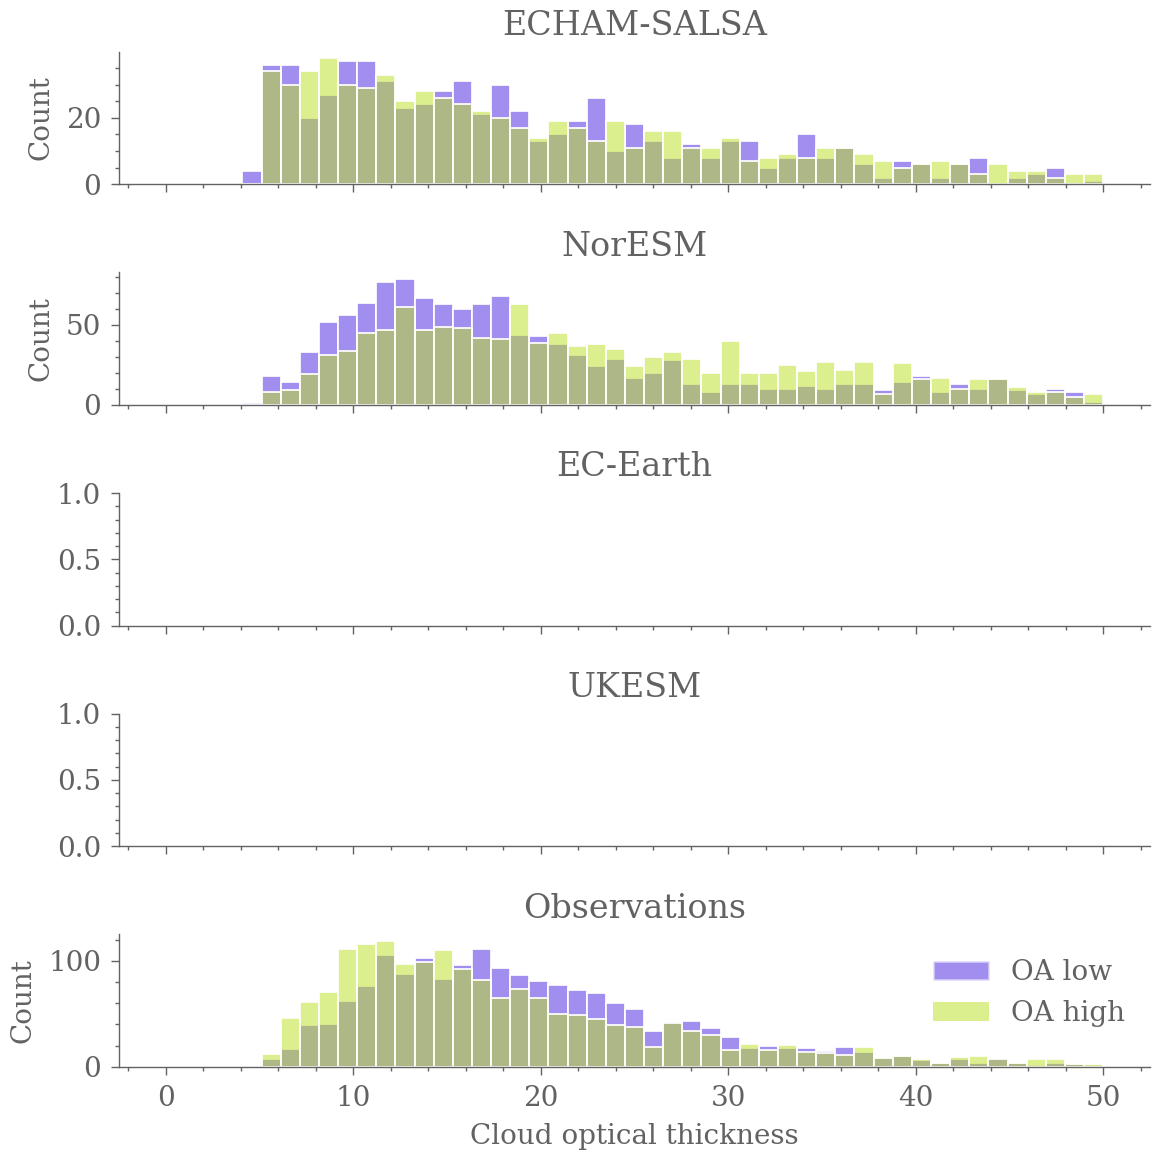

In [193]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_bins = np.linspace(0,50)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    ax.set_title(key)
    if key in ['EC-Earth','UKESM']:
        continue
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins=_bins,
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



5381
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JA.png


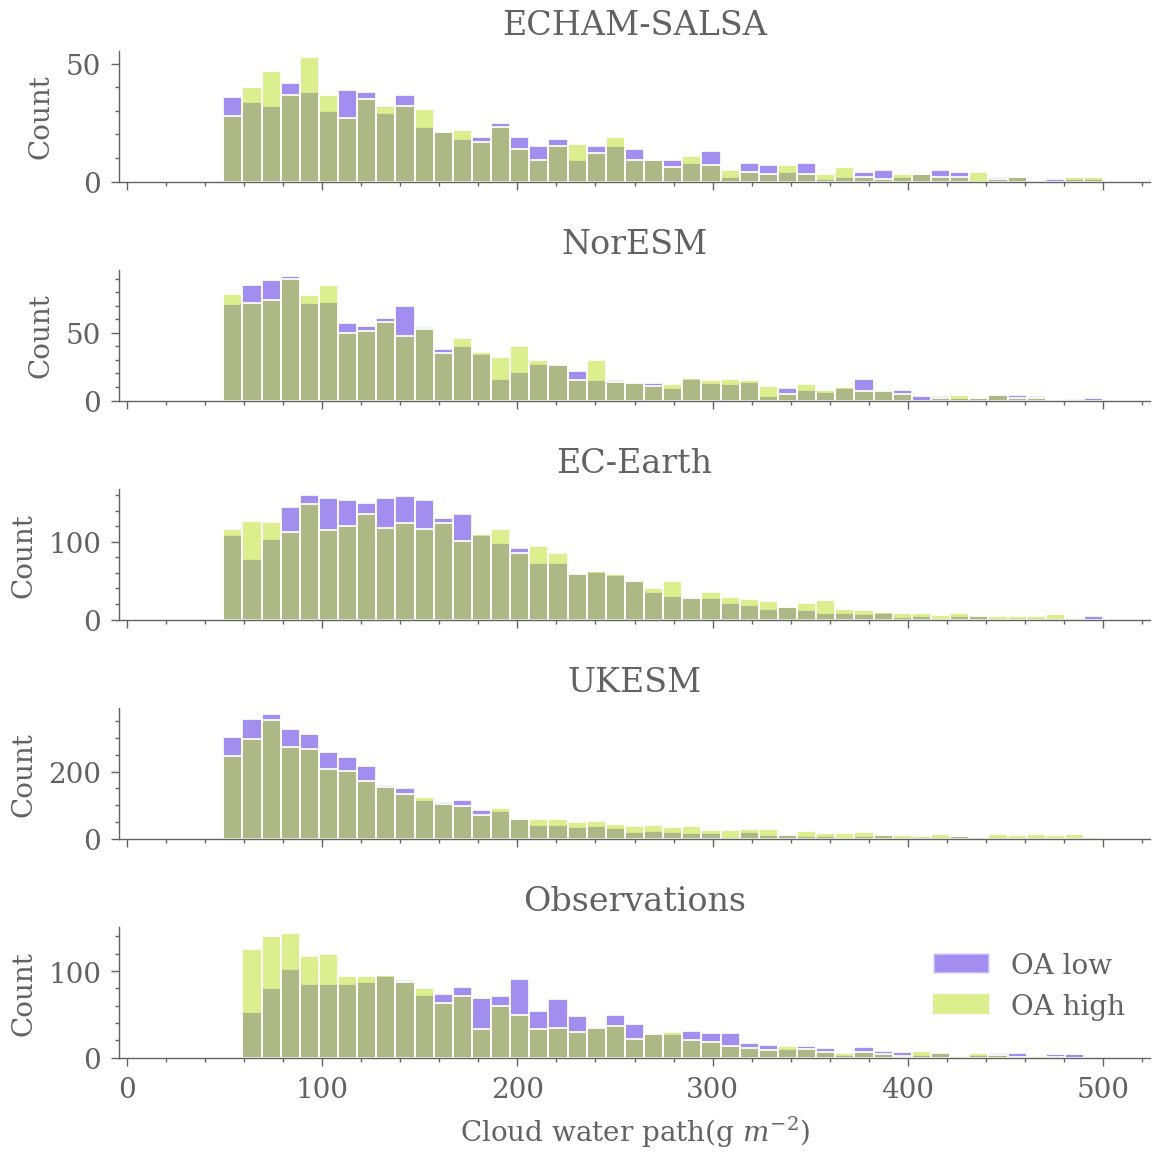

In [194]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])

v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_bins = np.linspace(20,500)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



<AxesSubplot:ylabel='Frequency'>

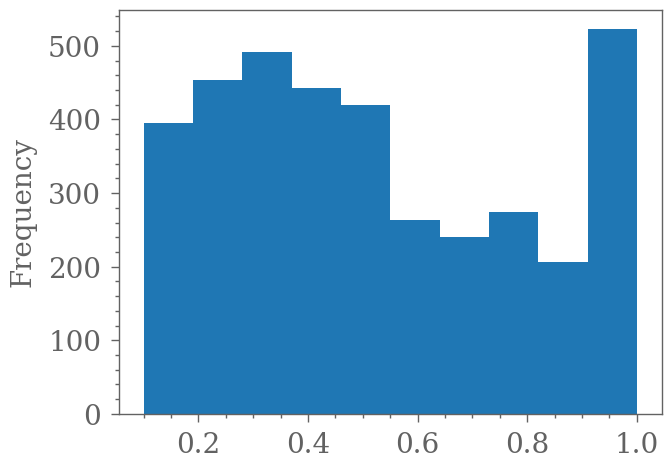

In [195]:
_df = dic_df['NorESM']
_df['FCTL'].plot.hist()

In [196]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

2022

2022
3710
8214
11185
5400
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_JA.png


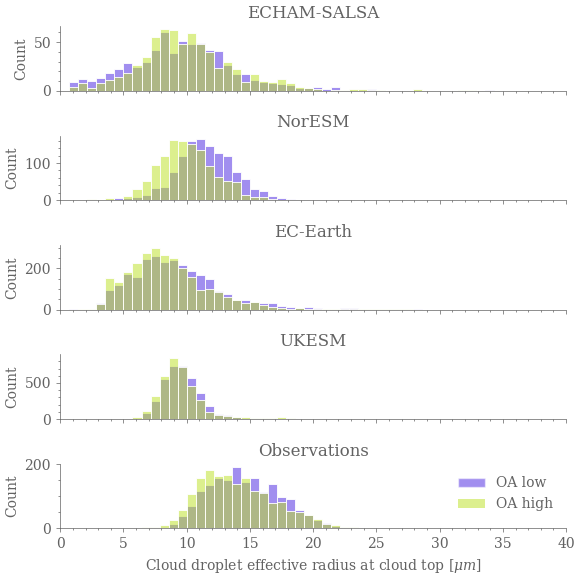

In [197]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_bins = np.linspace(0,35)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins=_bins
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1786
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_JA.png


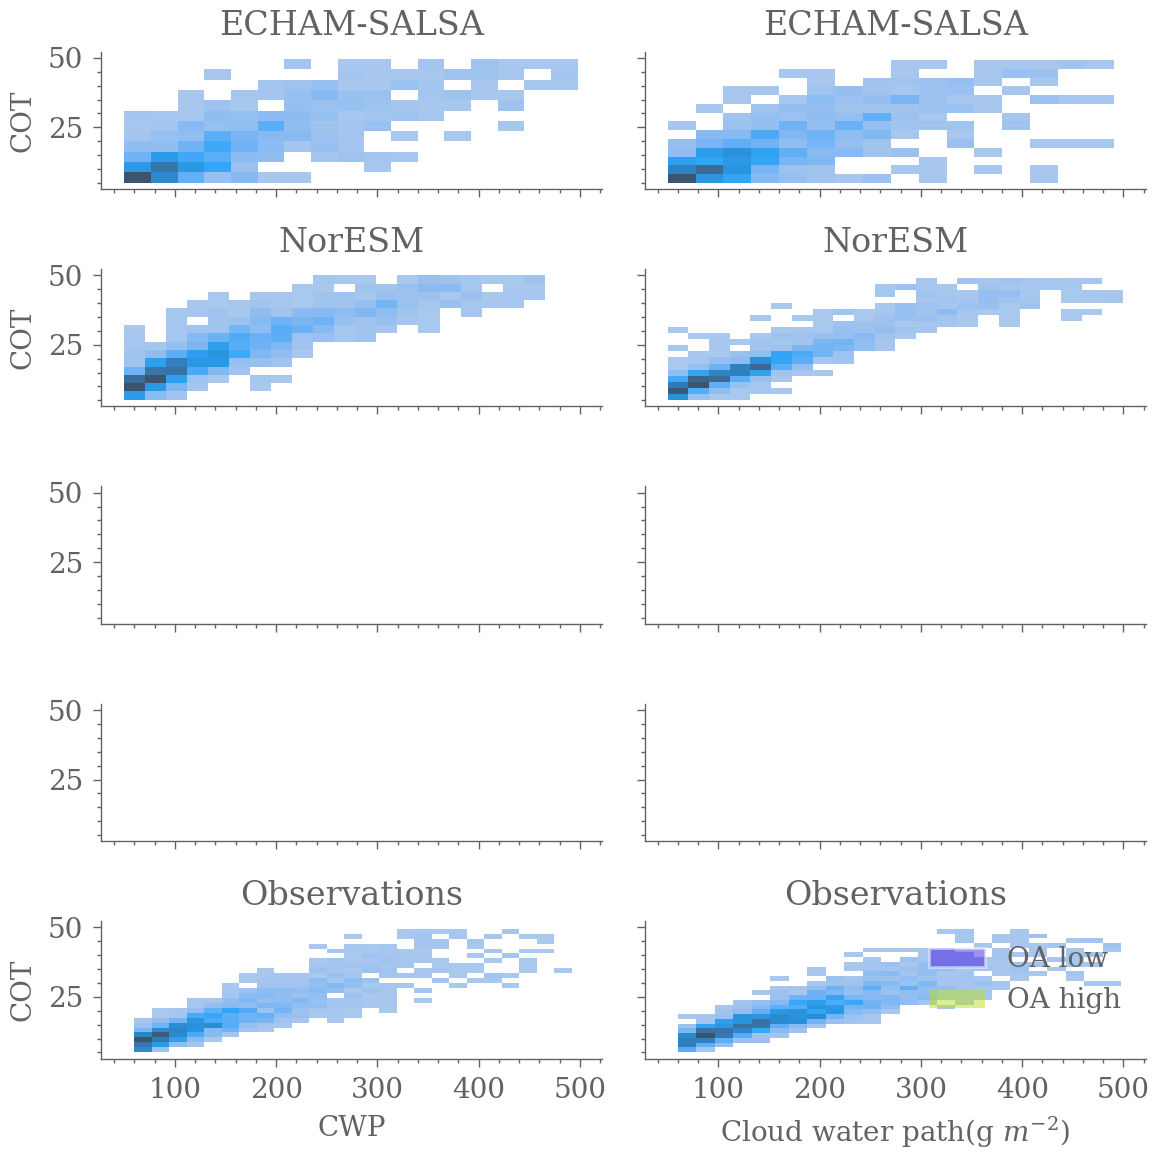

In [198]:
fig, axs = plt.subplots(5,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        if (key in ['EC-Earth','UKESM']) and (v_y=='COT'):
            continue
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



# Calculate difference between high OA and low


In [199]:
from bs_fdbck_clean.util.plot.BSOA_plots import cdic_model

In [200]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [201]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [202]:
from sklearn.utils import resample

## Bootstrap resampling 

In [203]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [204]:
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

itterations = 1000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key in ['EC-Earth', 'UKESM']) and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
261
length of 75 is 170 and 192
number of days is 84 and 102
1000
length of 118 is 162 and 152
number of days is 85 and 83
1000
length of 159 is 103 and 114
number of days is 64 and 74
1000
length of 206 is 86 and 75
number of days is 57 and 48
1000
length of 253 is 55 and 54
number of days is 43 and 39
1000
length of 295 is 39 and 29
number of days is 31 and 24
1000
length of 382 is 55 and 54
number of days is 32 and 40
1000
NorESM
Total number of days:
219
length of 72 is 374 and 353
number of days is 70 and 110
1000
length of 112 is 273 and 277
number of days is 71 and 91
1000
length of 154 is 220 and 193
number of days is 63 and 66
1000
length of 199 is 107 and 154
number of days is 46 and 63
1000
length of 241 is 74 and 78
number of days is 35 and 41
1000
length of 287 is 53 and 64
number of days is 22 and 35
1000
length of 365 is 127 and 104
number of days is 30 and 33
1000
EC-Earth
UKESM
Observations
Total number of days:
158
length of 79 is 321

In [205]:
v = 'COT'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)
    print(fn)
    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

ECHAM-SALSA
Plots/cloud_props_ECHAM-SALSA_sample_stats_OA_COT_JA.csv
0.9471782093283587
NorESM
Plots/cloud_props_NorESM_sample_stats_OA_COT_JA.csv
3.305888552427582
Observations
Plots/cloud_props_Observations_sample_stats_OA_COT_JA.csv
0.9525381225718585


In [206]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)
    print(fn) 

    

ECHAM-SALSA
Plots/cloud_props_ECHAM-SALSA_sample_stats_OA_r_eff_JA.csv
NorESM
Plots/cloud_props_NorESM_sample_stats_OA_r_eff_JA.csv
EC-Earth
Plots/cloud_props_EC-Earth_sample_stats_OA_r_eff_JA.csv
UKESM
Plots/cloud_props_UKESM_sample_stats_OA_r_eff_JA.csv
Observations
Plots/cloud_props_Observations_sample_stats_OA_r_eff_JA.csv


# Final plot: 

In [207]:
import scienceplots
import scienceplots
plt.style.use([
    'default',
    # 'science',
    'acp',
    # 'sp-grid',
    'no-black',
    'no-latex',
    'illustrator-safe'
])

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_JA.png


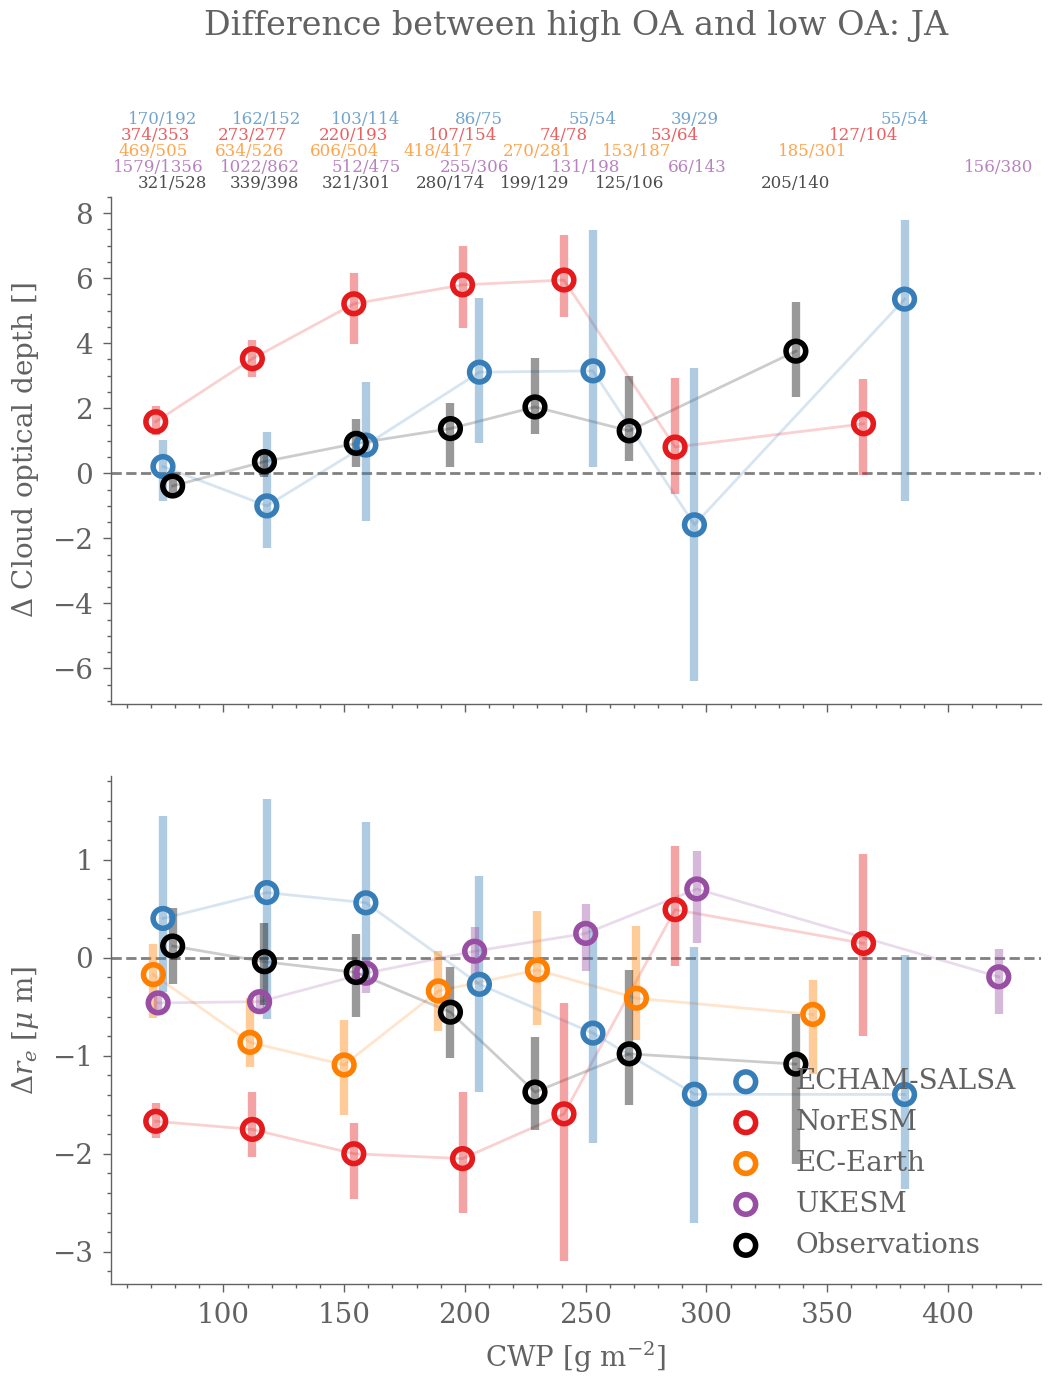

In [208]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    for key in dic_df.keys():
        if (key in ['EC-Earth', 'UKESM']) and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=key,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

In [212]:
dic_median_CI[y_var].keys()#[key]['sample_median']

dict_keys(['ECHAM-SALSA', 'NorESM', 'Observations'])

## Supplementary plots

In [213]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [214]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 55.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 43.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cut2lm_JA.png


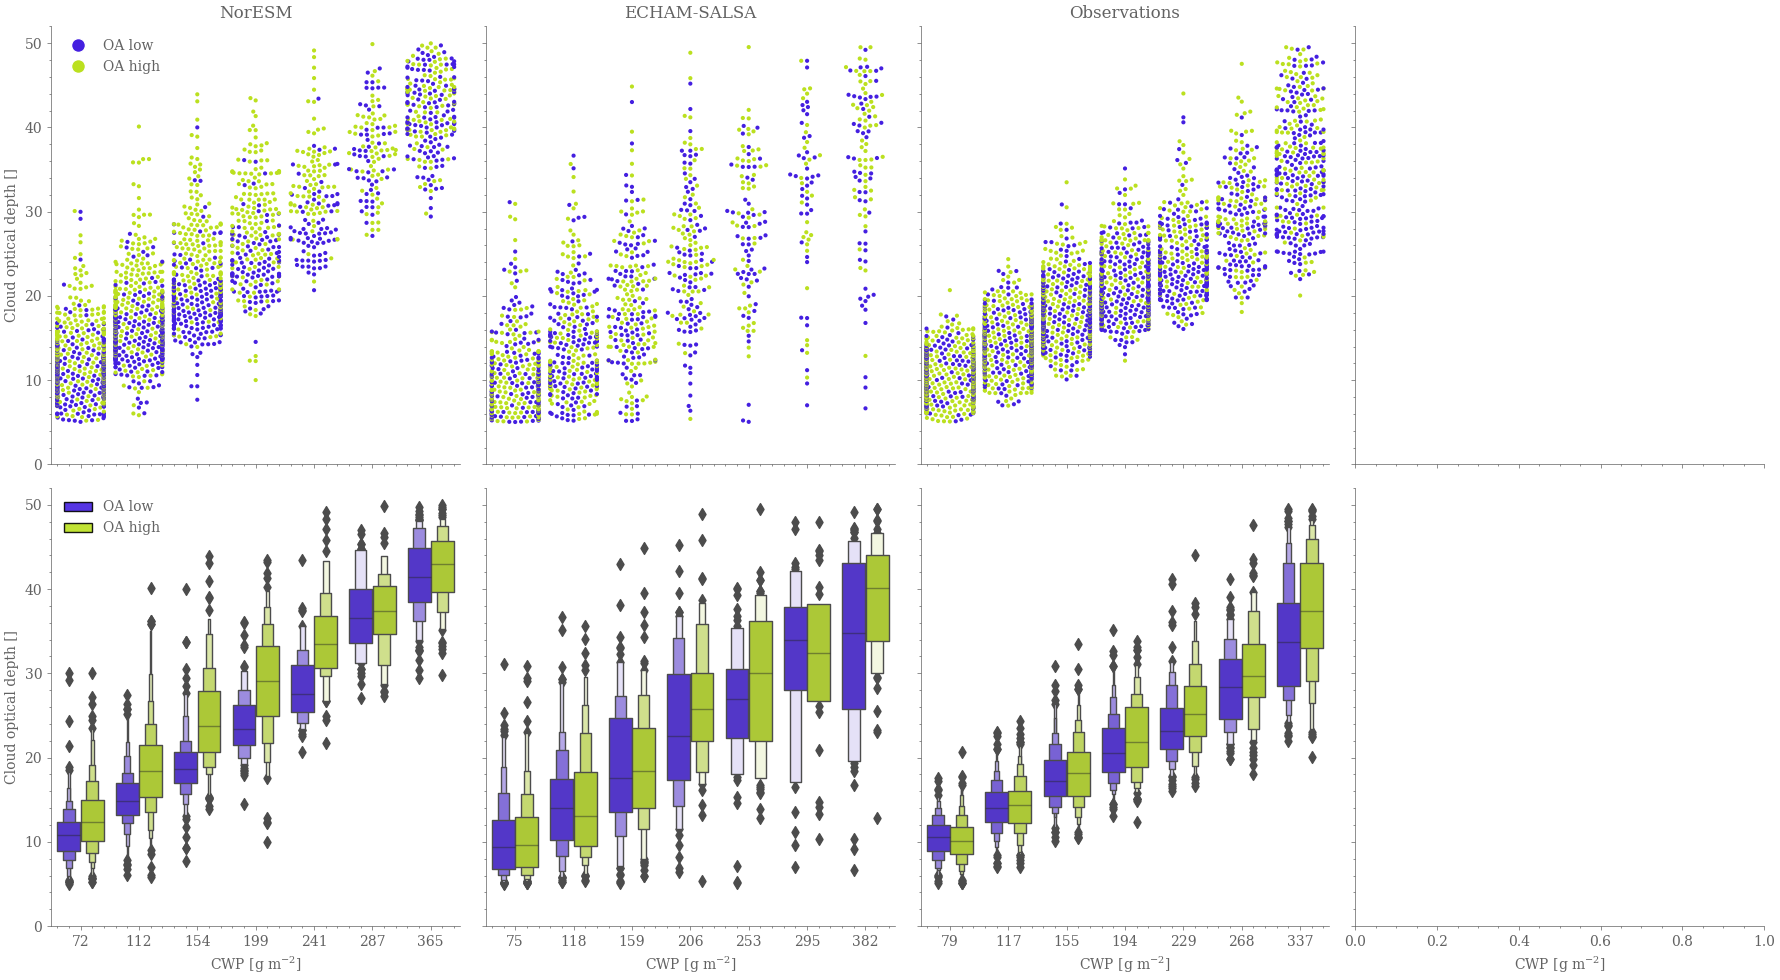

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cut2lm_JA.png


In [215]:
x_var = 'CWP_cut2lm'

y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,4,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 3


for key,ax in zip(order_keys, axs[0,:]):
    if (key=='EC-Earth') and (y_var =='COT'):
        continue

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 34.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JA.png


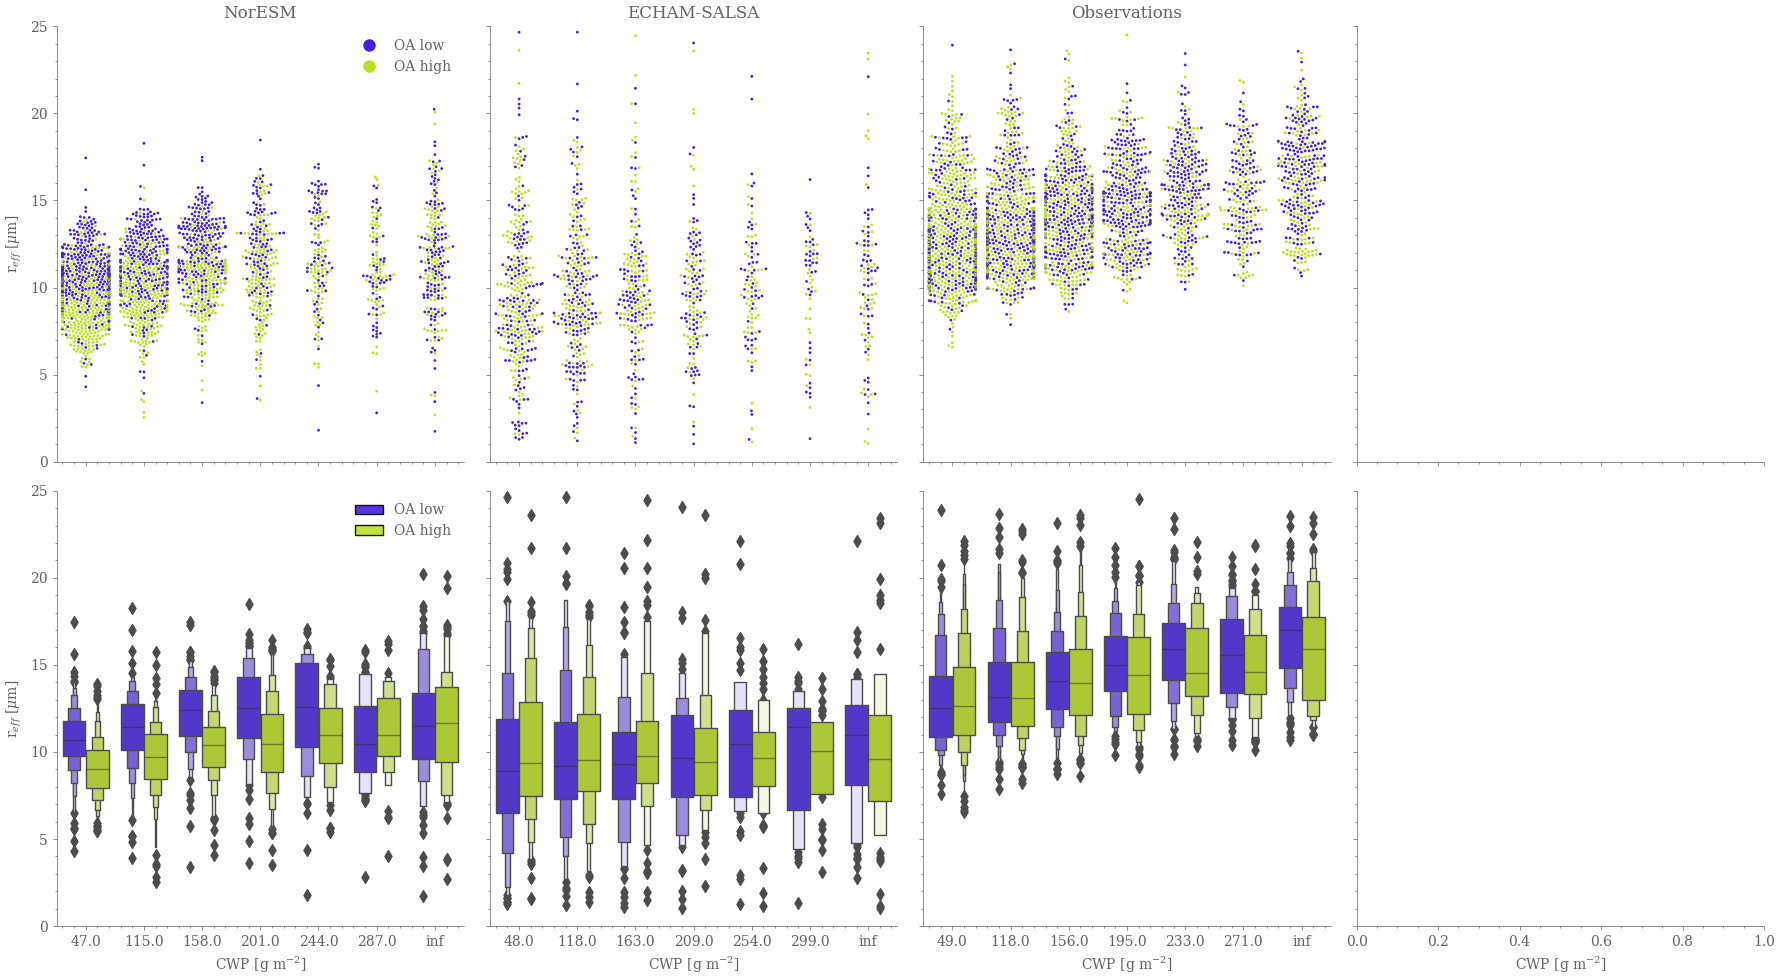

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_JA.png


In [216]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,4,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):
    if (key=='EC-Earth') and (y_var =='COT'):
        continue

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

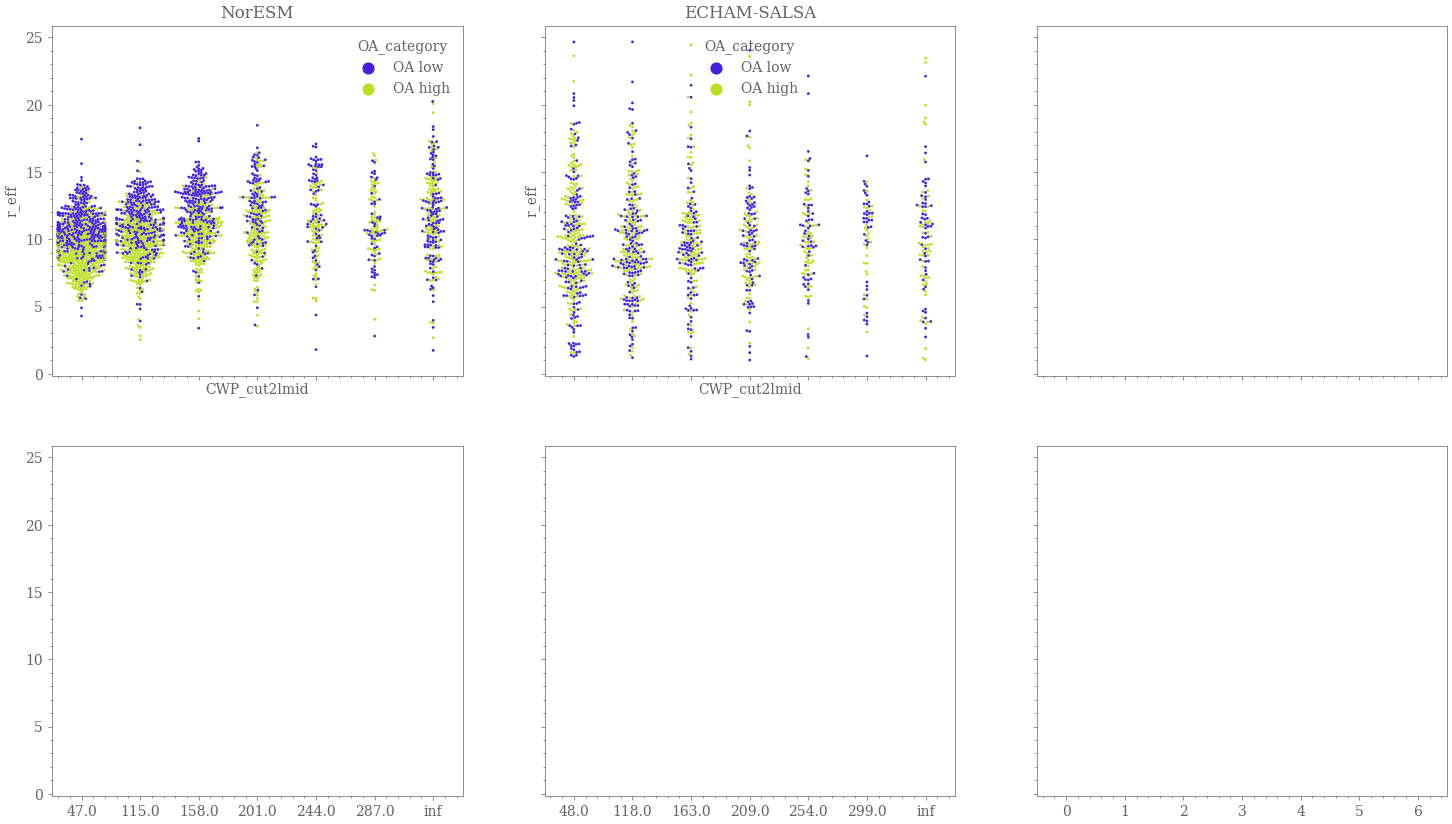

In [217]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

In [ ]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 10000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()